In [109]:
import os
import pandas as pd
import numpy as np
import tweepy
import time
from tweepy import OAuthHandler
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse
from requests_oauthlib import OAuth1
from newspaper import Article
from newspaper import Config
from transformers import pipeline
from newspaper import Config
from newspaper import Article
import traceback
import logging
import re
import urllib
from transformers import pipeline
from termcolor import colored
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoModelForSequenceClassification
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [110]:
#Assigning API/Access Keys
consumer_key = '91OBPUpS2KtpZ5u6QmjdLd81D'
consumer_secret = '7zKK17hHjFMlfUT8NPrQFQArAxyhJYhH8m7fxrwbM5crGgMDDk'
access_token = '1484372306231128071-Buh0RShEK5lIKUI92gogVoucJhvUmp'
access_secret = '43YVRS7kLMzn2jUnzDdrCIZKYdhtkcJEmDn1wXnuio1vC'
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [111]:
#Add the user Id you want to get tweets  - Currently using CNN's user_id
user_id="759251"
#Add the number of tweets you want to get
number_of_tweets= 10
#count: maximum allowed tweets count
#tweet_mode: extended to get the full text,it prevents a primary tweet longer than 140 characters from being truncated.
timeline = api.user_timeline(user_id=user_id,count=number_of_tweets,tweet_mode="extended")
# Iterate and print tweets
tweet_text = [tweet.full_text for tweet in timeline]
tweet_ids = [tweet.id for tweet in timeline]
tweet_df = pd.DataFrame()
tweet_df['Tweet ID'] = tweet_ids
tweet_df['Text'] = tweet_text
#Storing tweet ids and text in a csv file for later use
tweet_df.to_csv('tweets.csv')


In [112]:
#Reading relevant tweet ids from csv file
tweets = pd.read_csv("tweets.csv")


In [115]:
#Function to extract article links from tweet texts
def get_article_links(tweets):
    article_links = []
    for tweet in tweets['Text'].to_numpy():
            urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet)
            for i in range(len(urls)):
                res = urllib.request.urlopen(urls[i].strip())
                urls[i] = res.geturl()
                print("expanded url = " + urls[i])
                #Checking if the expanded url is an external link to an article, as opposed to a twitter link
                if("twitter.com" not in urls[i] and urls[i] not in article_links):
                    article_links.append(urls[i])
    return article_links
              
#Function to extract relevant information from news articles given links as inputs
def get_articles(article_links):
    articles = []
    for url in article_links:
        try:
            article = Article(url.strip())
            article.download() 
            article.parse()
            date = article.publish_date
            authors = ", ".join(author for author in article.authors)
            title = article.title
            #Formatting date
            if date is not None:
                date = date.strftime("%m/%d/%Y")
            else:
                date = ''
                
            text = article.text
            url = article.url
            articles.append(
            {
                'Author': authors,
                'Title': title,
                'Date': date,
                'Link': url,
                'Text': text
            }
            )
        except Exception as e:
            logging.error(traceback.format_exc())
    return articles


#Function that performs summarization to summarize article text, and sentiment analysis to get the sentiment of article title.
def summarization_and_sentiment(articles):
    summaries = []
    #Pretrained Model for Summarization
    model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
    tokenizer = AutoTokenizer.from_pretrained("t5-base")

    Title_Sentiments = []

    for index,article in articles.iterrows():
        # T5 uses max_length of 512
        inputs = tokenizer("summarize: " + articles['Text'].iloc[index], return_tensors="pt", max_length=512, truncation=True)
        outputs = model.generate(
            inputs["input_ids"], max_length=120, min_length=40, length_penalty=2.0, num_beams=2, early_stopping=True
        )
        summary = tokenizer.decode(outputs[0])
        #Removing unneccesary characters from summary
        summary = re.sub('<[^>]+>', '', summary).strip()
        
        summaries.append(summary)

        #Pretrained Model for Sentiment Analysis of Article Title
        sentiment_analyzer = SentimentIntensityAnalyzer()
        sentence = article['Title']
        score = sentiment_analyzer.polarity_scores(sentence)
        if score['compound'] >= 0.05 :
            Title_Sentiments.append('Positive')
        elif score['compound'] <= - 0.05 :
            Title_Sentiments.append('Negative')
        else:
            Title_Sentiments.append('Neutral')

    articles['Title Sentiment'] = Title_Sentiments
    articles['Summary'] = summaries
    return articles

# Function to plot word clouds from article content
def cloud_plot(word_cloud):
    # Set figure size
    plt.figure(figsize=(6, 4.5))
    # Display image
    plt.imshow(word_cloud)
    #Removing axis
    plt.axis("off");
    plt.show();

#Function to display information in the articles dataframe in an organized manner
def display_articles(articles):
    for index,article in articles.iterrows():
        print(colored(article['Title'].upper(), attrs=['bold']))
        print(colored("By: ", attrs=['bold']) + article['Author'])
        print(colored("Summary:\n", attrs=['bold']) + article['Summary'])
        print(colored("Date: ", attrs=['bold']) + article['Date'])
        print(articles['Link'].iloc[index])
        sentiment_color = 'blue'
        if(article["Title Sentiment"].lower() == 'positive'):
            sentiment_color = 'green'

        elif(article["Title Sentiment"].lower() == 'negative'):
            sentiment_color = 'red'

        print(colored("Title Sentiment: ", attrs=['bold']) +  colored(article["Title Sentiment"], sentiment_color , attrs=['bold']) + '\n')

        # Generate word cloud
        word_cloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(article['Summary'])
        # Plot
        cloud_plot(word_cloud)


In [116]:
article_links = get_article_links(tweets)

expanded url = https://www.cnn.com/2022/01/25/entertainment/neil-young-spotify-joe-rogan-vaccine-misinformation-cec/index.html?utm_content=2022-01-26T15%3A45%3A25&utm_source=twCNN&utm_term=link&utm_medium=social
expanded url = https://www.cnn.com/2022/01/26/politics/us-allies-discuss-deploying-more-troops/index.html?utm_medium=social&utm_term=link&utm_source=twCNN&utm_content=2022-01-26T15%3A35%3A50
expanded url = https://www.cnn.com/
expanded url = https://twitter.com/CNN/status/1486360781507764234/video/1
expanded url = https://www.cnn.com/2022/01/25/asia/us-f-35-crash-recovery-south-china-sea-intl-hnk-ml/index.html
expanded url = https://twitter.com/CNN/status/1486358254938734598/video/1
expanded url = https://www.cnn.com/2022/01/26/sport/aaron-rodgers-accountability-divisive-packers-nfl-spt-intl/index.html?utm_source=twCNN&utm_term=link&utm_medium=social&utm_content=2022-01-26T15%3A19%3A45
expanded url = https://www.cnn.com/2022/01/26/investing/boeing-losses/index.html?utm_content=

In [117]:
articles = get_articles(article_links)

articles = pd.DataFrame(articles)

In [118]:
articles

,Author,Title,Date,Link,Text
0,Scottie Andrew,Neil Young wants his music scrubbed from Spoti...,01/25/2022,https://www.cnn.com/2022/01/25/entertainment/n...,"(CNN) Neil Young, an outspoken advocate for Co..."
1,"Jim Sciutto, Natasha Bertrand",US and allies discussing deploying more troops...,01/26/2022,https://www.cnn.com/2022/01/26/politics/us-all...,(CNN) The US and a handful of allies are in di...
2,,"Breaking News, Latest News and Videos",,https://www.cnn.com/,
3,Brad Lendon,US Navy wants to get crashed stealth fighter b...,01/25/2022,https://www.cnn.com/2022/01/25/asia/us-f-35-cr...,"Seoul, South Korea (CNN) The United States Nav..."
4,Jack Bantock,Aaron Rodgers claims vaccination status was th...,01/26/2022,https://www.cnn.com/2022/01/26/sport/aaron-rod...,(CNN) Green Bay Packers quarterback Aaron Rodg...
5,"Chris Isidore, Cnn Business",Boeing posts massive charge for 787 Dreamliner...,01/26/2022,https://www.cnn.com/2022/01/26/investing/boein...,New York (CNN Business) Boeing took nearly $4 ...
6,"Story Reuters, Cnn Weather'S Pedram Javaheri, ...",Snow blankets Greece and Turkey as wild weathe...,01/25/2022,https://www.cnn.com/2022/01/25/weather/weather...,(CNN) A rare and severe snowstorm has blankete...
7,"Priscilla Alvarez, Jasmine Wright",Harris heading to Honduras under pressure to f...,01/26/2022,https://www.cnn.com/2022/01/26/politics/kamala...,(CNN) Vice President Kamala Harris will lead a...
8,"Paul R. La Monica, Cnn Business","A year after GameStop mania, meme stocks have ...",01/26/2022,https://www.cnn.com/2022/01/26/investing/meme-...,New York (CNN Business) It's been a little mor...
9,"Kylie Atwood, Jennifer Hansler",Biden admin to send Russia written responses a...,01/26/2022,https://www.cnn.com/2022/01/26/politics/us-rus...,(CNN) The Biden administration is set to send ...


In [119]:
articles = summarization_and_sentiment(articles)

NEIL YOUNG WANTS HIS MUSIC SCRUBBED FROM SPOTIFY BECAUSE OF VACCINE MISINFORMATION ON THE PLATFORM
By: Scottie Andrew
Summary:
"they can have Rogan or Young. Not both," 76-year-old says. "the Joe Rogan Experience" was Spotify's most popular podcast in 2021. a group of scientists, doctors and nurses penned an open letter to Spotify condemning the streamer.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/entertainment/neil-young-spotify-joe-rogan-vaccine-misinformation-cec/index.html?utm_content=2022-01-26T15%3A45%3A25&utm_source=twCNN&utm_term=link&utm_medium=social
Title Sentiment: Negative



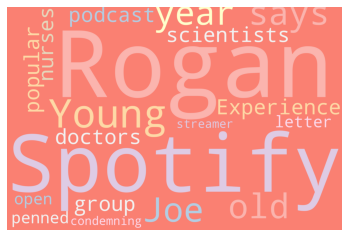

US AND ALLIES DISCUSSING DEPLOYING MORE TROOPS TO EASTERN EUROPE PRIOR TO ANY RUSSIAN INVASION OF UKRAINE
By: Jim Sciutto, Natasha Bertrand
Summary:
the deployments would be similar to the forward battle groups currently stationed in the Baltic States and Poland. the US and a handful of allies are in discussions to deploy thousands more troops to eastern european NATO countries. the move could be weaponized by the Kremlin as an example of the kind of aggressive NATO posture.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/politics/us-allies-discuss-deploying-more-troops/index.html?utm_medium=social&utm_term=link&utm_source=twCNN&utm_content=2022-01-26T15%3A35%3A50
Title Sentiment: Neutral



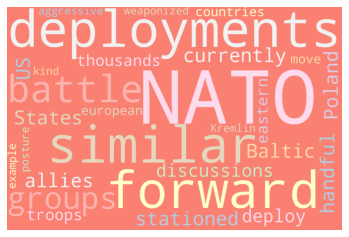

BREAKING NEWS, LATEST NEWS AND VIDEOS
By: 
Summary:
. - (EN).................
Date: 
https://www.cnn.com/
Title Sentiment: Neutral



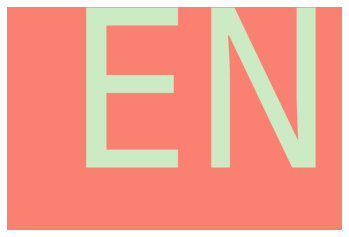

US NAVY WANTS TO GET CRASHED STEALTH FIGHTER BACK -- BEFORE CHINA CAN
By: Brad Lendon
Summary:
the single-engine stealth fighter crashed-landed on the aircraft carrier USS Carl Vinson. the $100 million warplane impacted the flight deck of the 100,000-ton aircraft carrier. it then fell into the sea as its pilot ejected, and six sailors aboard the Vinson were injured. analysts say the complex operation will be closely monitored by china.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/asia/us-f-35-crash-recovery-south-china-sea-intl-hnk-ml/index.html
Title Sentiment: Positive



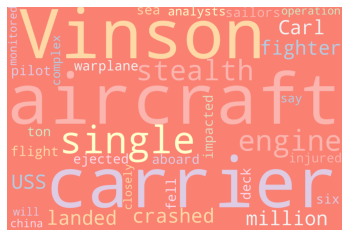

AARON RODGERS CLAIMS VACCINATION STATUS WAS THE 'ONLY REASON' PEOPLE WANTED PACKERS TO LOSE IN THE PLAYOFFS
By: Jack Bantock
Summary:
green bay Packers quarterback says he takes accountability for being "divisive" despite not intending to be a polarizing figure. rodgers reappeared on the "the pat McAfee Show" to reflect on playoff loss. the 37-year-old says he has empathy for the "fear" he believes the covid-19 pandemic has caused.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/sport/aaron-rodgers-accountability-divisive-packers-nfl-spt-intl/index.html?utm_source=twCNN&utm_term=link&utm_medium=social&utm_content=2022-01-26T15%3A19%3A45
Title Sentiment: Negative



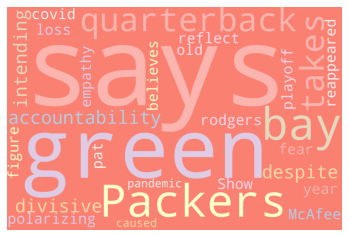

BOEING POSTS MASSIVE CHARGE FOR 787 DREAMLINER PROBLEMS, SENDING LOSSES SOARING
By: Chris Isidore, Cnn Business
Summary:
company says it will have to pay $3.5 billion to compensate customers for the delayed deliveries. it only delivered 14 of the planes in 2021, none since June. delays will increase the costs of producing the plane by an estimated $2 billion.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/investing/boeing-losses/index.html?utm_content=2022-01-26T15%3A03%3A11&utm_source=twCNN&utm_term=link&utm_medium=social
Title Sentiment: Negative



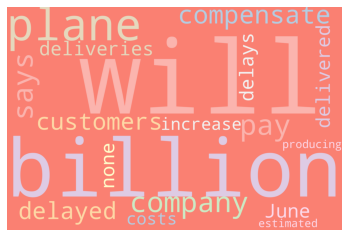

SNOW BLANKETS GREECE AND TURKEY AS WILD WEATHER SYSTEM CREATES RARE 'SNOWNADO'
By: Story Reuters, Cnn Weather'S Pedram Javaheri, Robert Shackelford
Summary:
storm Elpida blankets parts of Greece and Turkey with heavy snow. athens has only seen six snow events since 2000. more than 3,500 people evacuated by early Tuesday, some abandoning their cars.
Date: 01/25/2022
https://www.cnn.com/2022/01/25/weather/weather-climate-snowstorm-greece-turkey-intl/index.html
Title Sentiment: Positive



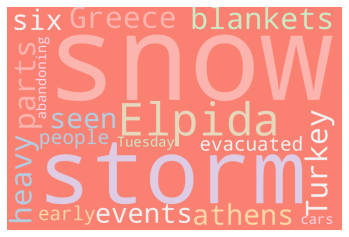

HARRIS HEADING TO HONDURAS UNDER PRESSURE TO FIND A RELIABLE PARTNER IN NORTHERN TRIANGLE
By: Priscilla Alvarez, Jasmine Wright
Summary:
vp Kamala Harris will lead a delegation to Honduras this week. she will attend the historic inauguration of president-elect Xiomara Castro. the visit will mark a pivot from the vice president's approach to the previous leader.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/politics/kamala-harris-honduras/index.html?utm_content=2022-01-26T14%3A53%3A21&utm_term=link&utm_medium=social&utm_source=twCNN
Title Sentiment: Negative



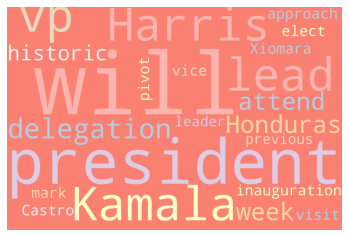

A YEAR AFTER GAMESTOP MANIA, MEME STOCKS HAVE TUMBLED
By: Paul R. La Monica, Cnn Business
Summary:
share prices of GameStop have plunged nearly 35% in January, while AMC has plummeted more than 40%. millennials and Gen Z members have started to realize investing can be a way to build long-term wealth. some experts say the rise of meme stocks is a good thing, if for no other reason than it helps democratize the market.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/investing/meme-stocks-gamestop-amc-reddit/index.html?utm_source=twCNN&utm_term=link&utm_medium=social&utm_content=2022-01-26T14%3A37%3A17
Title Sentiment: Neutral



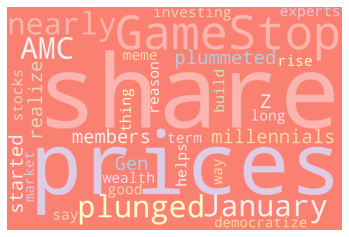

BIDEN ADMIN TO SEND RUSSIA WRITTEN RESPONSES AS SOON AS WEDNESDAY
By: Kylie Atwood, Jennifer Hansler
Summary:
the proposal will lay out the general areas where the US is willing to work with Russia. the details will go "slightly deeper" than what the US has said publicly. the proposal will be shared with Russia at some time this week.
Date: 01/26/2022
https://www.cnn.com/2022/01/26/politics/us-russia-ukraine/index.html?utm_content=2022-01-26T14%3A27%3A57&utm_source=twCNN&utm_term=link&utm_medium=social
Title Sentiment: Neutral



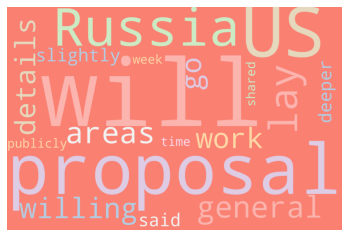

In [120]:
display_articles(articles)
# If you particularly want to display maths, this is more direct:


None
